# **House price prediction with PyCaret Library**

# 1. Installation

Install Pycaret and Pandas Libraries

In [233]:
#!pip install pycaret
#!pip install pandas

# 2. Import libraries

In [234]:
from pycaret.clustering import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Read train csv file

In [235]:
data = pd.read_csv('../data/train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# 4. Preprocess data before clustering

### 4.1 Check columns that contain empty or Nan values

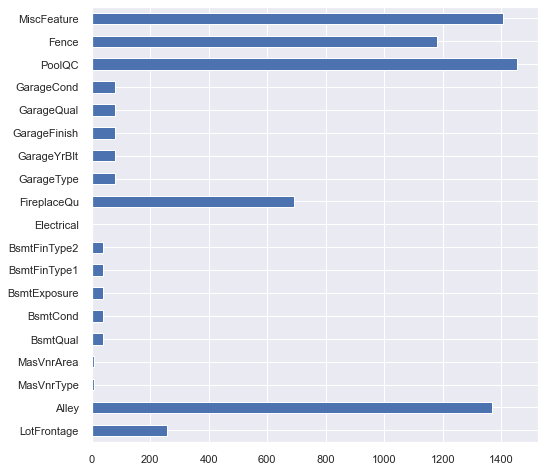

In [236]:
data_null = data.isna().sum()
plt.figure(figsize=(8,8))
data_null[data_null!=0].plot(kind='barh');

### 4.2 Drop the five columns with few values and the id column too

In [237]:
data.drop(['Id','Alley','PoolQC','FireplaceQu','Fence','MiscFeature'],axis=1, inplace=True)

### 4.3 The column LotFrontage, we fill the missing values with median values.

In [238]:
data['LotFrontage'].fillna(data['LotFrontage'].median(),inplace=True)

### 4.4 Drop all the Nan values since they are a small part of the dataset

In [239]:
data.dropna(inplace=True)

### 4.5 Keep only the neccesary numerical values and drop the other ones which have same values

In [240]:
data.drop(['BsmtFinSF2','LowQualFinSF','BsmtHalfBath','KitchenAbvGr',\
            'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal'],axis=1,inplace=True)

### 4.6 Keep only the neccesary categorical values and drop thoose with nearly same values

In [241]:
data_new = data.drop(['Utilities','LandSlope','Condition1','Condition2','BldgType','Street','RoofMatl','ExterCond','BsmtCond',\
'Heating','CentralAir','Electrical','Functional','GarageQual','GarageCond','PavedDrive','MSZoning','SaleType','SaleCondition',\
                     'LandContour','BsmtFinType2'],axis=1)

### 4.7 Correlation Plot to understand feature correlation

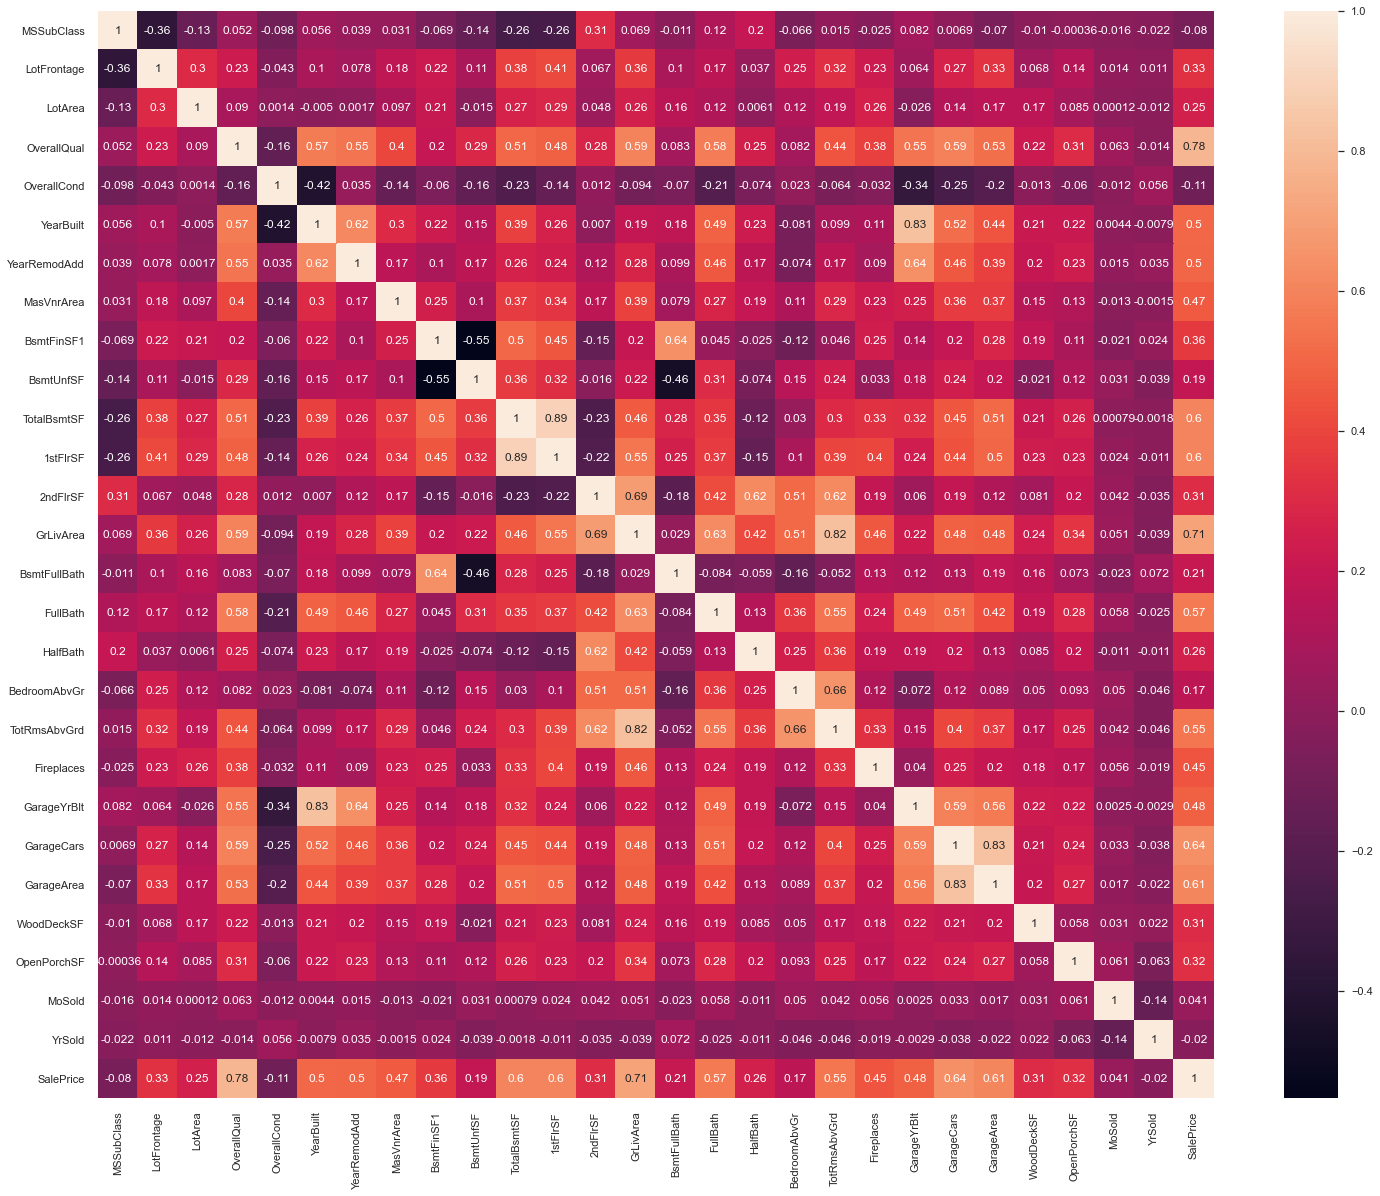

In [242]:
plt.figure(figsize=(25,20))
sns.set(font_scale=1)
sns.heatmap(data_new.corr(),annot=True);

### 4.8 Drop the most correlated columns to avoid overfitting

In [243]:
data_new.drop(['TotRmsAbvGrd','TotalBsmtSF','GarageCars','GarageYrBlt'],axis=1,inplace=True)

### 4.9 Split features to categorical and numerical

In [244]:
numer = set(data_new.corr()['SalePrice'].index)
categ = list(set(data_new.columns) - set(data_new.corr()['SalePrice'].index))

### 4.10 Caterogical to numerical features except the ordinal ones

In [245]:
data_targ = data_new.copy()
categ_fact = set(categ) - set(['ExterQual','BsmtQual','BsmtExposure','HeatingQC','KitchenQual'])
for i in categ_fact:
    data_targ[i] = data_targ[i].factorize()[0]
    
data_targ.drop(['SalePrice'],axis=1,inplace=True)
data_targ.head(6)

,MSSubClass,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,YearBuilt,...,BedroomAbvGr,KitchenQual,Fireplaces,GarageType,GarageFinish,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold
0,60,65.0,8450,0,0,0,0,7,5,2003,...,3,Gd,0,0,0,548,0,61,2,2008
1,20,80.0,9600,0,1,1,1,6,8,1976,...,3,TA,1,0,0,460,298,0,5,2007
2,60,68.0,11250,1,0,0,0,7,5,2001,...,3,Gd,1,0,0,608,0,42,9,2008
3,70,60.0,9550,1,2,2,0,7,5,1915,...,3,Gd,1,1,1,642,0,35,2,2006
4,60,84.0,14260,1,1,3,0,8,5,2000,...,4,Gd,1,0,0,836,192,84,12,2008
5,50,85.0,14115,1,0,4,2,5,5,1993,...,1,TA,0,0,1,480,40,30,10,2009


### 4.11 Target hist and boxplot

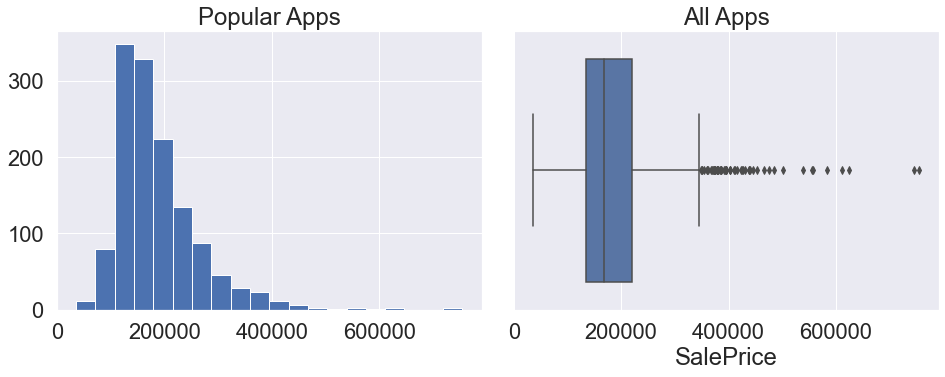

In [246]:
fig = plt.figure(figsize=(20,10))
sns.set(font_scale=2)
ax1 = fig.add_subplot(2,3,1)
ax1.set_title('Popular Apps')
data_new['SalePrice'].hist(bins=20);
ax2 = fig.add_subplot(2,3,2)
ax2.set_title('All Apps')
sns.boxplot(data_new['SalePrice'])
plt.tight_layout()

# 5. Pycaret Clustering

### 5.1 Pycaret setup function after data preprocessing

In [247]:
clu1 = setup(data = data_targ,
             normalize = True, 
             normalize_method = 'minmax', 
             transformation = True, 
             transformation_method = 'yeo-johnson', 
             ordinal_features= {'ExterQual': ['Fa', 'TA', 'Gd', 'Ex'],
                                'BsmtQual' : ['Fa', 'TA', 'Gd', 'Ex'], 
                                'BsmtExposure' : ['No', 'Mn', 'Av', 'Gd'],
                                'HeatingQC' : ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                'KitchenQual' : ['Fa', 'TA', 'Gd', 'Ex'],
                                },
             silent = True
             )

,Description,Value
0,session_id,3615
1,Original Data,"(1338, 40)"
2,Missing Values,False
3,Numeric Features,14
4,Categorical Features,26
5,Ordinal Features,True
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(1338, 166)"
9,CPU Jobs,-1


### 5.2 Create model

In [248]:
kmeans = create_model('kmeans')

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.099,144.8532,2.7466,0,0,0


### 5.3 Plot the model with TSNE

In [249]:
plot_model(kmeans, plot = 'tsne')